# ERT inversion - beyond the standard

Here, we exemplify the possibilities of pyGIMLi by treating an ERT timelapse data set. Most of the strategies are independent on the method and can be used for other types of data.

The data set here was published by Hübner et al. (2017) and describes a shallow infiltration experiment using a surface electrode layout.


In [130]:
# We import some basic libraries like numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [131]:
# Furthermore we import pygimli and two of its modules
import pygimli as pg
from pygimli.physics import ert
import pygimli.meshtools as mt

From the whole timelapse set of data files we load a single one, show its properties.

In [132]:
data = ert.load("020.dat")
print(data)

Data: Sensors: 392 data: 2849, nonzero entries: ['a', 'b', 'm', 'n', 'r', 'valid']


The data contains 2849 data using 392 electrodes. In the data container, there are the A-B-M-N numbers of the electrodes and resistances (`'r'`). We first plot the electrode positions.

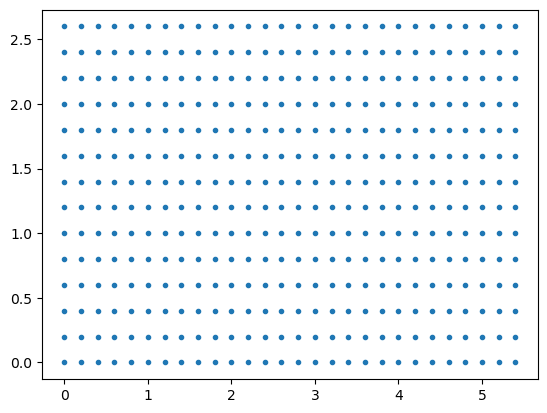

In [133]:
plt.plot(pg.x(data), pg.y(data), ".")

We first compute geometric factors and apparent resistivities and store both in the data container.

In [134]:
data["k"] = ert.geometricFactors(data)
data["rhoa"] = data["r"] * data["k"]

The data exhibit mostly dipole-dipole data measured with a 12-channel ABEM Terrameter LS2 instrument. To fill up the channels, some multi-gradient and some square arrays have been added. We can have a look at the data by using `data.show()` (`ert.show(data)`). 

16/03/24 - 09:12:51 - pyGIMLi - INFO - found 245 x values
16/03/24 - 09:12:51 - pyGIMLi - INFO - found 143 y values
16/03/24 - 09:12:51 - pyGIMLi - INFO - x vector length: 2849
16/03/24 - 09:12:51 - pyGIMLi - INFO - y vector length: 2849
16/03/24 - 09:12:51 - pyGIMLi - INFO - v vector length: 2849
16/03/24 - 09:12:51 - pyGIMLi - INFO - 1390 data of 2849 not shown


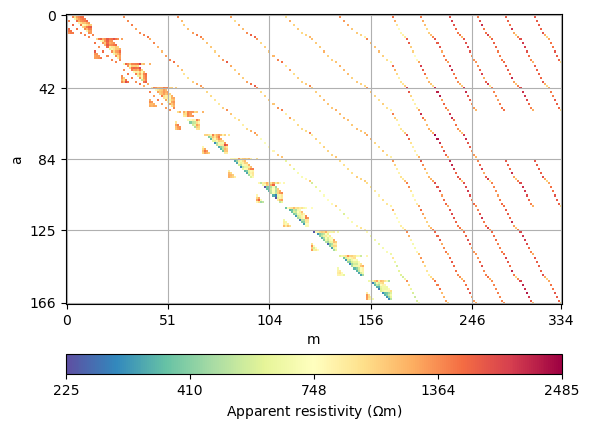

In [135]:
data.show(style="A-M");

We can already see the pseudosections on the main diagonal with some reciprocals mirrored at the diagonal, plus some measurements between the lines (off-diagonals).

In [136]:
# check reciprocals
iFwd, iBwd = ert.reciprocalIndices(data)
print(len(iFwd), len(iBwd))

214 214


We have a very limited amount of reciprocal data pairs with which we can do a reciprocal analysis.

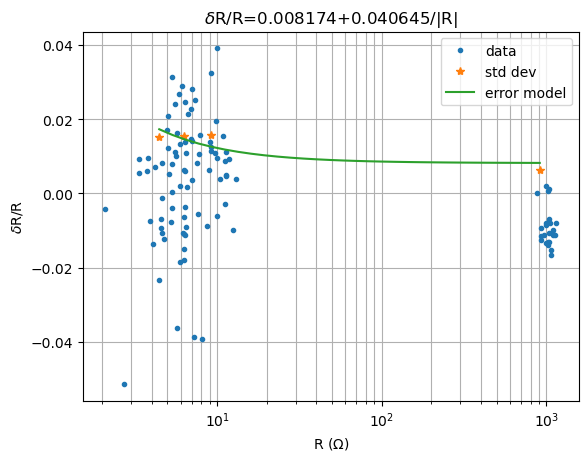

In [137]:
ert.fitReciprocalErrorModel(data, show=True, rel=True);

The number is not large enough and the distribution of R bimodal (DD vs. MG array). For an example with more rigorous data and background of normal-reciprocal analysis see https://www.pygimli.org (needs to be transferred from https://github.com/gimli-org/notebooks/blob/main/ERT/reciprocal/reciprocalAnalysis.ipynb)
Nevertheless, we estimate a data error using 1% and 70mOhm.

In [138]:
data.estimateError(relativeError=0.01, absoluteError=0.07)
print(min(data["err"]), max(data["err"]))
# data.show("err", style="A-M")

0.010027533256240216 0.010463484076011388


We extract a single profile from the data.

Detecting small distances, using mm accuracy


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1f3ca6f66d0>)

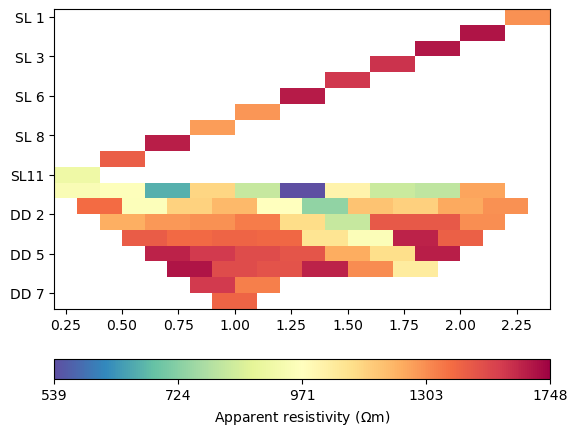

In [139]:
x0 = data.subset(x=0)
x0.setSensors(np.column_stack([pg.y(x0), pg.x(x0)])) # auto for x/y
x0.show()

The upper part is a single multi-gradient using the outermost electrodes, the lower a dipole-dipole section. If we think.

Detecting small distances, using mm accuracy


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1f3ca9ced00>)

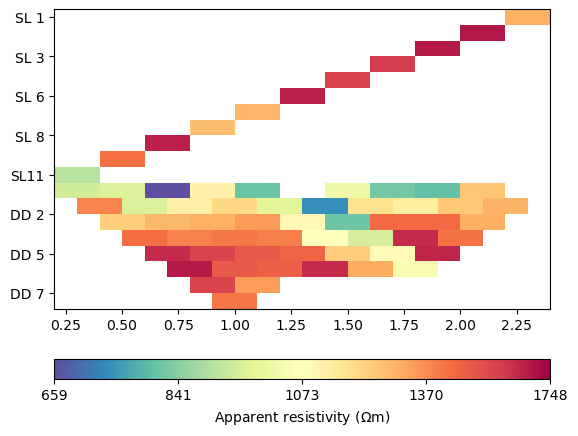

In [140]:
x0.remove(x0["rhoa"] < 600)
x0.show()

In [141]:
mgr = ert.Manager(x0)
mgr.invert(verbose=True)

16/03/24 - 09:12:52 - pyGIMLi - INFO - Found 2 regions.
16/03/24 - 09:12:52 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
16/03/24 - 09:12:52 - pyGIMLi - INFO - Found 2 regions.
16/03/24 - 09:12:52 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
16/03/24 - 09:12:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/03/24 - 09:12:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/03/24 - 09:12:52 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 760 Cells: 1412 Boundaries: 1112
16/03/24 - 09:12:52 - pyGIMLi - INFO - Use median(data values)=1340.4949999999994
16/03/24 - 09:12:52 - pyGIMLi - INFO - Created startmodel from forward operator: 186, min/max=1340.495000/1340.495000
16/03/24 - 09:12:52 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001F3CAC70900>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001F3CAC70CC0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001F3CAC709A0>
min/max (data): 659/1748
min/max (error): 1%/1.01%
min/max (start model): 1340/1340
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  539.00
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   65.94 (dPhi = 87.32%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    4.20 (dPhi = 87.29%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    3.42 (dPhi = 9.07%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    3.29 (dPhi = 1.46%) lam: 20.0
################

186 [852.133840622905,...,2003.062375179683]

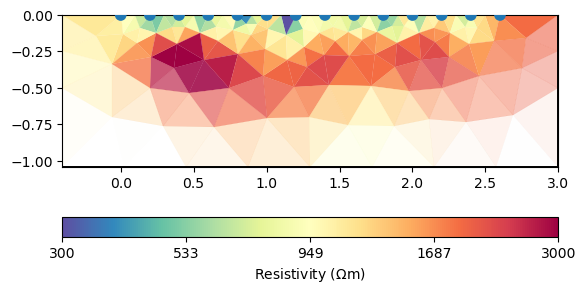

In [142]:
# We show the result
# mgr.showResult()
# eventually using a predefined color-scale
kw = dict(cMin=300, cMax=3000, cMap="Spectral_r", logScale=True)#,
        #   xlabel="x (m)", ylabel="z (m)")
ax, cb = mgr.showResult(**kw)
# we can further modify the figure using the axis and colorbar handles

In [143]:
x0result = mgr.paraDomain.copy()
x0result["res"] = mgr.model
x0result.setDimension(3)
x0result.swapCoordinates(1, 2)
x0result.swapCoordinates(0, 1)
x0result.boundingBox()


BoundingBox [RVector3: (0.0, -0.39999999999999997, -1.04), RVector3: (0.0, 3.0, 0.0)]

Data: Sensors: 14 data: 139, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid', 'ya', 'yb', 'ym', 'yn']
Detecting small distances, using mm accuracy


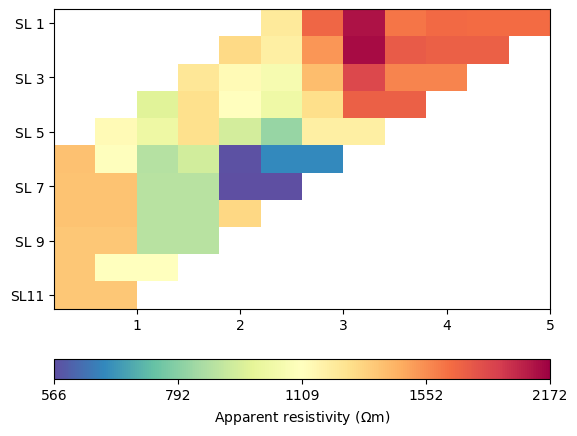

In [144]:
y1 = data.subset(y=0.6)
y1.setSensors(y1.sensors() * np.array([1, 0, 0]))  # auto
print(y1)
y1.show();

16/03/24 - 09:12:54 - pyGIMLi - INFO - Found 2 regions.
16/03/24 - 09:12:54 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
16/03/24 - 09:12:54 - pyGIMLi - INFO - Found 2 regions.
16/03/24 - 09:12:54 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
16/03/24 - 09:12:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/03/24 - 09:12:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/03/24 - 09:12:54 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 760 Cells: 1412 Boundaries: 1112
16/03/24 - 09:12:54 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
16/03/24 - 09:12:54 - pyGIMLi - INFO - Created startmodel from forward operator: 186, min/max=1227.930000/1227.930000
16/03/24 - 09:12:54 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001F3C52DF4F0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001F3C52DF3B0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001F3C3A6B280>
min/max (data): 566/2172
min/max (error): 1%/1.01%
min/max (start model): 1228/1228
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  772.11
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   41.10 (dPhi = 94.63%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    4.19 (dPhi = 88.41%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.42 (dPhi = 56.72%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    0.92 (dPhi = 24.01%) lam: 

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1f3bb5f9af0>)

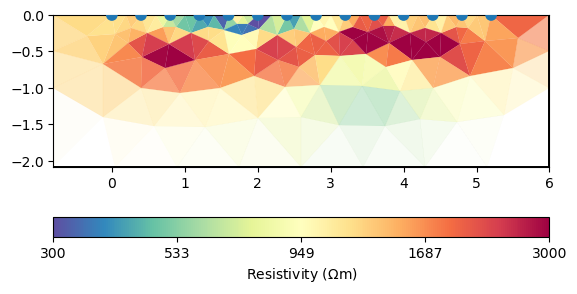

In [145]:
mgr = ert.Manager(y1)
mgr.invert(zWeight=0.3, verbose=True)
mgr.showResult(**kw)

We bring the 2d result into 3D

In [146]:
y1result = mgr.paraDomain.copy()
y1result["res"] = mgr.model
y1result.setDimension(3)
y1result.swapCoordinates(1, 2)
y1result.translate([0, 0.6, 0])
y1result.boundingBox()
# pg.show(y1result, "res", **kw)

BoundingBox [RVector3: (-0.7999999999999999, 0.6, -2.08), RVector3: (6.0, 0.6, 0.0)]

In [147]:
from pygimli.viewer import pv
kw = dict(cMin=300, cMax=3000, logScale=True, cMap="Spectral_r")
pl, _ = pg.show(x0result, "res", **kw, hold=True)
pv.drawMesh(pl, y1result, label="res", **kw)
pl.show()

Widget(value='<iframe src="http://localhost:56152/index.html?ui=P_0x1f3c52f2400_12&reconnect=auto" class="pyvi…

## References
* Hübner, R., Günther, T., Heller, K., Noell, U. & Kleber, A. (2017): Impacts of a capillary barrier on infiltration and subsurface stormflow in layered slope deposits monitored with 3-D ERT and hydrometric measurements. Hydrol. Earth Syst. Sci. 21, 5181-5199, doi:10.5194/hess-21-5181-2017.
